In [1]:
import pandas as pd
from sklearn import preprocessing
from scipy.interpolate import RectBivariateSpline, griddata
from io import StringIO
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def get_sample(filename='./108000/MapGrid1.txt', num=1):
    with open(filename, 'r') as file:
        text = file.read()
    lines = text.split('Frac_num')[num].splitlines()[1:]
    result = pd.read_csv(StringIO('\n'.join(lines)), delim_whitespace=True,
                         names=['X', 'Y', 'value'])
    return result

In [3]:
def normalize_and_get_inverse(df):
    normalized = (df - df.min()) / (df.max() - df.min())
    inverse = lambda data: data * (df.max() - df.min()) + df.min()
    return normalized, inverse

In [14]:
def interpolate_and_compute_in_grid(sample, method='linear', grid=None):
    if grid is None:
        grid_x, grid_y = np.mgrid[0:0.01:100j, 0:0.01:100j]
    else:
        grid_x, grid_y = grid

    normalized, inverse = normalize_and_get_inverse(sample)
    points = normalized[['X', 'Y']].values
    values = normalized[['value']].values.reshape(-1)
    grid_result = griddata(points, values, (grid_x, grid_y), method=method)
    return grid_result

In [15]:
s1 = get_sample(num=4)

In [16]:
grid = interpolate_and_compute_in_grid(s1)

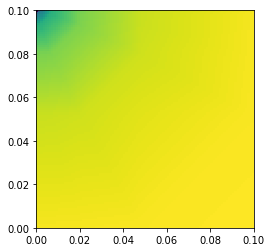

In [17]:
plt.imshow(grid.T, extent=(0, 0.1, 0, 0.1))